In [2]:
from Bio import SeqIO
import numpy as np

# helper functions

In [511]:
def levenshtein(x, y, in_del_cost = 2, mismatch_cost = 1):
    x = "_" + x
    y = "_" + y
    field = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        field[i,0] = i * in_del_cost
    for j in range(len(y)):
        field[0,j] = j * in_del_cost
    #print("Start:")
    #toString(x, y, field)

    for j in range(len(y) - 1):
        j = j + 1
        for i in range(len(x) - 1):
            i = i + 1
            field[i,j] = min(field[i-1,j-1] + match_mismatch(x[i], y[j], match_score=0, mismatch_cost=mismatch_cost),
            field[i -1, j] + in_del_cost,
            field[i,j-1] + in_del_cost)
    #print("Result:")
    #toString(x, y, field)
    #return field
    return field[len(x) - 1, len(y) - 1]

def toString(x, y, field):
    print("\t" + "\t".join([str(k) for k in range(len(x))]))
    print("\t" + "\t".join(x))
    for j in range(len(y)):
        print(str(j) + " " + y[j] + "\t" + "\t".join([str(int(number)) for number in field[:,j]]))

def match_mismatch(letter_x, letter_y, match_score, mismatch_cost):
    if letter_x == letter_y:
        return match_score
    else:
        return mismatch_cost

def local_alignment(x, y, in_del_cost = -2, match_score = 3, mismatch_cost = -1, search_number = 0):
    x = "_" + x
    y = "_" + y
    field = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        field[i,0] = 0
    for j in range(len(y)):
        field[0,j] = 0
    #print("Start:")
    #toString(x, y, field)

    for j in range(len(y) - 1):
        j = j + 1
        for i in range(len(x) - 1):
            i = i + 1
            field[i,j] = max(field[i-1,j-1] + match_mismatch(x[i], y[j], match_score, mismatch_cost),
                field[i -1, j] + in_del_cost,
                field[i,j-1] + in_del_cost,
                0)
    #print("Result:")
    #toString(x, y, field)
    return field
    #count_search_number = 0
    #for i in range(len(x)):
    #    for j in range(len(y)):
    #        if field[i,j] == search_number:
    #            count_search_number += 1
    #print(search_number," appeared ", count_search_number, " times")

def backtrack(field, in_del_cost, mismatch_cost, s1, s2):
    alignment = ""
    # set index to lower right cell in cost matrix of pairwise alignment
    x, y = field.shape[0] - 1, field.shape[1] - 1
    while (x != 0) and (y != 0):
        if (field[x, y] == field[x-1, y-1]) and (s1[x - 1] == s2[y - 1]): #s1[x - 1] == s2[y - 1] -> -1 here because original string is missing "_" in front (see levenshtein())
            alignment = "M" + alignment
            x, y = x-1, y-1
        elif field[x, y] == field[x-1, y-1] + mismatch_cost:
            alignment = "X" + alignment
            x, y = x-1, y-1
        elif field[x, y] == field[x-1, y] + in_del_cost:
            alignment = "D" + alignment
            x += -1
        elif field[x, y] == field[x, y - 1] + in_del_cost:
            alignment = "I" + alignment
            y += -1
    if x == 0:
        while y != 0:
            alignment = "I" + alignment
            y += -1
    else:
        while x != 0:
            alignment = "D" + alignment
            x += -1
    return alignment

def backtrack_to_strings(backtrack, s1, s2):
    new_s1, new_s2 = "", ""
    for operation in backtrack[::-1]:
        if operation == "M":
            new_s1 += s1[-1]
            new_s2 += s2[-1]
            s1 = s1[:-1]
            s2 = s2[:-1]
        elif operation == "I":
            new_s1 += "_"
            new_s2 += s2[-1]
            s2 = s2[:-1]
        elif operation == "D":
            new_s1 += s1[-1]
            new_s2 += "_"
            s1 = s1[:-1]
    return "_" + new_s1[::-1], "_" + new_s2[::-1]

class Operation:
    def __init__(self, value, operation, predecessor):
        self.value = value
        self.operation = operation
        self.predecessor = predecessor

class Ppm:
    def __init__(self, s1, vocab):
        s1 = "_" + s1
        self.seq = s1
        self.vocab = vocab + "_"
        self.aligned_seqs = 1
        self.absolute_matrix = np.zeros((len(s1), len(self.vocab)))
        for index_string in range(len(s1)):
            for index_vocab in range(len(self.vocab)):
                if s1[index_string] == self.vocab[index_vocab]:
                    self.absolute_matrix[index_string, index_vocab] += 1
        self.probability_matrix = self.absolute_matrix.copy()
    
    def toString(self):
        print("\t" + "\t".join([str(k) for k in range(len(self.seq))]))
        print("\t" + "\t".join(self.seq))
        for j in range(len(self.vocab)):
            print(str(j) + " " + self.vocab[j] + "\t" + "\t".join([str(number / self.aligned_seqs)[:4] for number  in self.absolute_matrix[:,j]]))

    def align_matrix_to_string(self, align_matrix):
        for y in range(align_matrix.shape[1]):
            print("\t".join([str(elem.value) for elem in align_matrix[:,y]]))

    def cost(self, c1, c2, in_del_cost, mismatch_cost):
        if c1 == c2:
            return 0
        elif (c1 == "_") or (c2 == "_"):
            return in_del_cost
        else:
            return mismatch_cost

    def cost_of_alignment_to_ppm(self, c, ppm_pos, in_del_cost, mismatch_cost):
        col = self.probability_matrix[ppm_pos,:]
        current_cost = 0
        for AA_index in range(len(self.vocab)):
            AA = self.vocab[AA_index]
            current_cost += self.cost(c, AA, in_del_cost, mismatch_cost) * col[AA_index]
        return current_cost

    def backtrack_seq_to_ppm(self, align_matrix):
        alignment_string = ""
        op = align_matrix[align_matrix.shape[0] - 1, align_matrix.shape[1] - 1]
        while op.predecessor is not None:
            alignment_string = op.operation + alignment_string
            op = op.predecessor
        return alignment_string

    def align(self, s2, mismatch_cost, in_del_cost):
        s2 = "_" + s2
        align_matrix = np.ndarray((len(self.seq), len(s2)), dtype=Operation)
        for y in range(len(s2)):
            for x in range(len(self.seq)):
                if y == 0:
                    if x == 0:
                        align_matrix[x, y] = Operation(0 , "", None)
                    else:
                        align_matrix[x, y] = Operation(align_matrix[x - 1, y].value + self.cost_of_alignment_to_ppm("_", x, in_del_cost, mismatch_cost), "D", align_matrix[x - 1, y])
                elif x == 0:
                    align_matrix[x, y] = Operation(align_matrix[x, y - 1].value + in_del_cost, "I", align_matrix[x, y-1])
                else:
                    insertion = Operation(align_matrix[x, y - 1].value + in_del_cost, "I", align_matrix[x, y - 1])
                    deletion = Operation(align_matrix[x - 1, y].value + self.cost_of_alignment_to_ppm("_", x, in_del_cost, mismatch_cost), "D", align_matrix[x - 1, y])
                    match_mismatch = Operation(align_matrix[x - 1, y - 1].value + self.cost_of_alignment_to_ppm(s2[y], x, in_del_cost, mismatch_cost), "M", align_matrix[x-1, y-1])
                    if (match_mismatch.value < deletion.value) and (match_mismatch.value < insertion.value):
                        align_matrix[x, y] = match_mismatch
                    elif deletion.value < insertion.value:
                        align_matrix[x, y] = deletion
                    else:
                        align_matrix[x, y] = insertion
        #self.align_matrix_to_string(align_matrix)
        return align_matrix

    def add(self, s2, mismatch_cost, in_del_cost):
        align_matrix = self.align(s2, mismatch_cost=mismatch_cost, in_del_cost=in_del_cost)
        backtrack_operations = self.backtrack_seq_to_ppm(align_matrix)
        #print("Backtrack operations: ", backtrack_operations)
        #print("len(backtrack_operations): ", len(backtrack_operations))
        s1_aligned, s2_aligned = backtrack_to_strings(backtrack_operations, self.seq, s2)
        self.seq = s1_aligned
        new_absolute_matrix = np.zeros((len(s1_aligned), len(self.vocab)))

        #print(s1_aligned)
        #print(s2_aligned)
        new_absolute_matrix[0,:] = self.absolute_matrix[0,:]
        new_absolute_matrix[0, -1] += 1
        index_without_insertions = 1

        for e in range(1, len(backtrack_operations) + 1):
            op = backtrack_operations[e - 1]
            if (op == "M") or (op == "D"):
                new_absolute_matrix[e,:] = self.absolute_matrix[index_without_insertions,:]
                new_absolute_matrix[e,self.vocab.index(s2_aligned[e])] += 1
                index_without_insertions += 1
            elif op == "I":
                new_absolute_matrix[e,self.vocab.index(s2_aligned[e])] = 1
                new_absolute_matrix[e,self.vocab.index("_")] = self.aligned_seqs
        
        self.absolute_matrix = new_absolute_matrix
        self.aligned_seqs += 1
        self.probability_matrix = self.absolute_matrix / self.aligned_seqs

    def compute_alignment_cost(self, s2, mismatch_cost, in_del_cost):
        align_matrix = self.align(s2, mismatch_cost=mismatch_cost, in_del_cost=in_del_cost)
        return align_matrix[align_matrix.shape[0]-1, align_matrix.shape[1]-1].value

    

# parse fasta

In [512]:
records = []
for record in SeqIO.parse("data/rad52.fasta", "fasta"):
    print(record.id)
    records.append(record)

concat_sequences = "".join([str(record.seq) for record in records])
vocabulary = ''.join(set(concat_sequences))

first_seq = str(records[0].seq[:10])
second_seq = str(records[1].seq[:10])

#levenshtein(first_seq, first_seq)

sp|P06778|RAD52_YEAST
sp|P43351|RAD52_HUMAN
sp|P43352|RAD52_MOUSE
sp|P41768|RAD52_KLULA
sp|Q6FSW2|RAD52_CANGA
sp|Q756F4|RAD52_ASHGO
sp|P39022|RAD52_CHICK


# create multiple sequence alignment (center star)

## find center string

In [513]:
def find_center_string(records, in_del_cost=2, mismatch_cost=1):
    pairwise_distance = {}
    for e in range(len(records)):
        for i in range(e, len(records)):
            if e == i:
                pass
            else:
                pairwise_distance[(e,i)] = levenshtein(str(records[e].seq), str(records[i].seq), in_del_cost=in_del_cost, mismatch_cost=mismatch_cost)
    center_pair = min(pairwise_distance, key=pairwise_distance.get)
    return center_pair

center_pair = find_center_string(records, in_del_cost=2, mismatch_cost=1)

In [514]:
center_pair

(1, 2)

## create PPM

In [515]:
s1 = records.pop(center_pair[0])
s2 = records.pop(center_pair[1])


mismatch_cost = 1
in_del_cost = 2


my_ppm = Ppm(s1, vocabulary)
my_ppm.add(s2, mismatch_cost=mismatch_cost, in_del_cost=in_del_cost)

## iteration

In [516]:
while len(records) > 0:
    pairwise_distance = {}
    for e in range(len(records)):
        pairwise_distance[e] = my_ppm.compute_alignment_cost(str(records[e].seq), mismatch_cost=mismatch_cost, in_del_cost=in_del_cost)
    best_string_index = min(pairwise_distance, key=pairwise_distance.get)
    my_ppm.add(records.pop(best_string_index), mismatch_cost=mismatch_cost, in_del_cost=in_del_cost)


# Plots

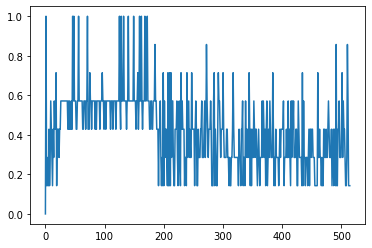

In [549]:
y = [np.max(my_ppm.probability_matrix[e,:-1]) for e in range(my_ppm.probability_matrix.shape[0])]

import matplotlib.pyplot as plt

plt.plot(y)

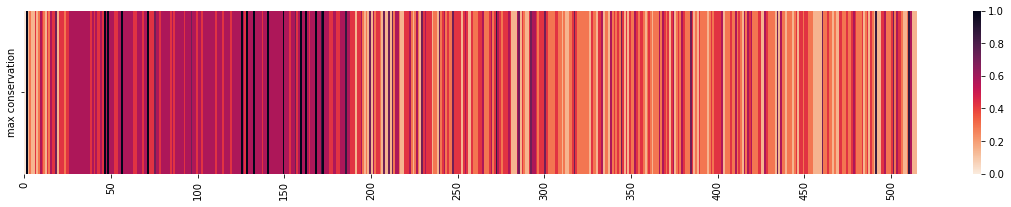

In [552]:
import pandas as pd
plt.figure(figsize=(20,3))
xticks = np.arange(0, my_ppm.probability_matrix.shape[0], 50)
df = pd.DataFrame({"max conservation": y}).transpose()
ax = sns.heatmap(df, cmap=sns.cm.rocket_r)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
plt.show()

[Text(0, 0, '0'),
 Text(50, 0, '50'),
 Text(100, 0, '100'),
 Text(150, 0, '150'),
 Text(200, 0, '200'),
 Text(250, 0, '250'),
 Text(300, 0, '300'),
 Text(350, 0, '350'),
 Text(400, 0, '400'),
 Text(450, 0, '450'),
 Text(500, 0, '500')]

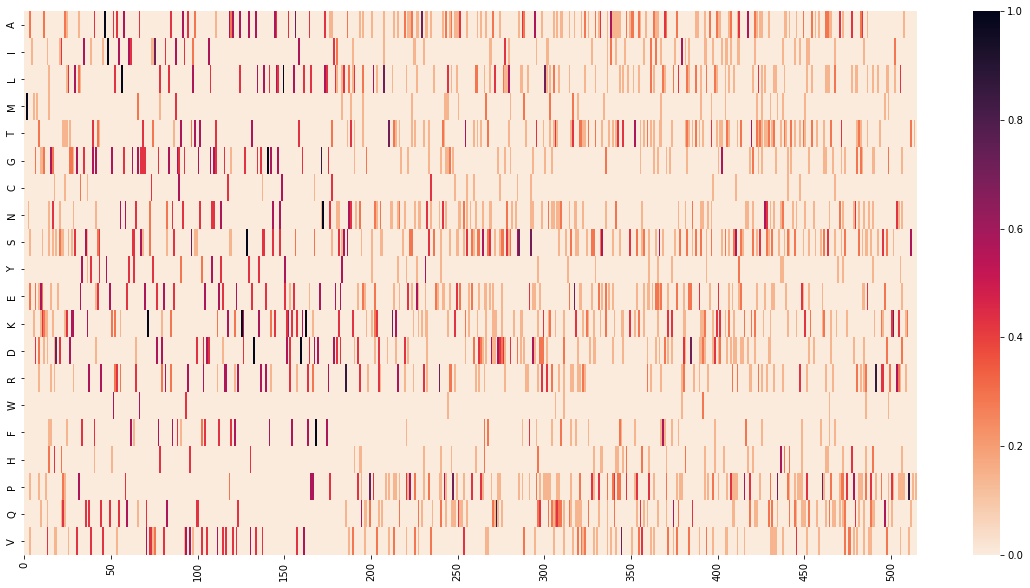

In [551]:
import seaborn as sns
plt.figure(figsize=(20,10))
xticks = np.arange(0, my_ppm.probability_matrix.shape[0], 50)
ax = sns.heatmap(my_ppm.probability_matrix[:,:-1].T, yticklabels=my_ppm.vocab[:-1], cmap=sns.cm.rocket_r)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)